### Import Library

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
np.random.seed(1)
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.layers.convolutional import Conv3D
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle

## Upload and preprocess the ModelNet10 Dataset

The input of the VoxNet should be voxel format. For ModelNet10, all the 3d model files are in pointclouds format. Thus, we use `binvox` (https://www.patrickmin.com/binvox/) as the tool to “voxelize” the data. 

`binvox` is a straight-forward program that reads a 3D model file, rasterizes it into a binary 3D voxel grid, and writes the resulting voxel file.

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip;

--2020-12-16 00:37:27--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  86.8MB/s    in 5.2s    

2020-12-16 00:37:33 (86.2 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!pip install path.py;
from path import Path
path = Path("ModelNet10")

In [4]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
print( 'Classes in ModelNet10: ')
classes

Classes in ModelNet10: 


{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

Here is how we use `binvox` in our local machine. 

 

1.   Download the `ModelNet10.zip` to our local and unzip it.
2.   Download the `binvox.exe` to our local.
3.   Open `cmd` and use `cd` to get into the ModelNet10 folder 
 
4.   `cd` to each subfolder that contains `.off` files. (eg. bathtub/test)
*   Run `for %i in (*.off) do BINVOXPATH -cb -e -c -d 30 "%i"` (eg.for %i in (*.off) do C:\Users\Downloads\binvox.exe -cb -e -c -d 30 "%i")
*   Run `del *.off`






Here we upload the ModelNet10 data that preprocessed by `binvox`.

In our GitHub Repo, we also provided the ModelNet10 data that have been processed by `binvox`. You can also download from [here](https://github.com/zilixie/3D-Shape-Classifiers/blob/main/VoxNet/ModelNet10_binvox.zip) and upload it to this notebook.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ModelNet10_binvox.zip to ModelNet10_binvox.zip


In [6]:
!unzip -q ModelNet10_binvox.zip;

Functions to read binary binvox format as array and convert the data into Voxels type.

More details about the functions please refer https://github.com/dimatura/binvox-rw-py

In [7]:
class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).
    dims, translate and scale are the model metadata.
    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.
    scale and translate relate the voxels to the original model coordinates.
    To translate voxel coordinates i, j, k to original coordinates x, y, z:
    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]
    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)


In [8]:
def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale
    
def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.
    Returns the model with accompanying metadata.
    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(np.bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

Wrap the data into testing and training sets.

In [9]:
ROOT = 'ModelNet10_binvox'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
y = {'train': [], 'test': []}
for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join('.', ROOT, cl, split)
        for example in os.listdir(examples_dir):
            if 'binvox' in example:
                with open(os.path.join(examples_dir, example), 'rb') as file:
                    data = np.int32(read_as_3d_array(file).data)
                    # padded_data = np.pad(data, 3, 'constant')
                    # X[split].append(padded_data)
                    X[split].append(data)
                    y[split].append(label)

Save the data in npz foramt.

In [10]:
np.savez_compressed('modelnet10_processed.npz',
                    X_train=X['train'],
                    X_test=X['test'],
                    y_train=y['train'],
                    y_test=y['test'])

In [11]:
modelnet_file = 'modelnet10_processed.npz'
data = np.load(modelnet_file)

In [12]:
X, Y = shuffle(data['X_train'], data['y_train'])
X_test, Y_test = shuffle(data['X_test'], data['y_test'])

In [13]:
print('the number of training samples: ' + str(len(data['X_train'])))
print('the number of testing samples: ' + str(len(data['X_test'])))
print('the size of each sample: ' + str(data['X_test'][1].size))
print("The number of classes: ",len(classes))

the number of training samples: 3991
the number of testing samples: 908
the size of each sample: 27000
The number of classes:  10


## Visulization

In [14]:
def drawVoxel(voxels):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(voxels)
    # ax.invert_zaxis()

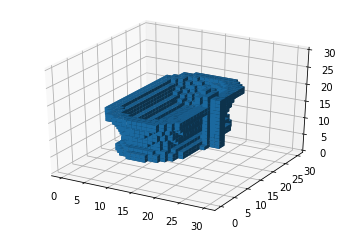

In [15]:
drawVoxel(X_test[1])

In [16]:
for label, num in classes.items():  
    if num == Y_test[1]:
        print("the label of this sample: " +label)

the label of this sample: bathtub


## Create VoxNet Model

In [36]:
model = Sequential()
model.add(Reshape((30, 30, 30, 1), input_shape=(30, 30, 30)))  # 1 in-channel
model.add(Conv3D(16, 6, strides=2, activation='relu'))
model.add(Conv3D(64, 5, strides=2, activation='relu'))
model.add(Conv3D(64, 5, strides=2, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 30, 30, 30, 1)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 13, 13, 13, 16)    3472      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 5, 5, 64)       128064    
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 1, 1, 64)       512064    
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 644,250
Trainable params: 644,250
Non-trainable params: 0
________________________________________________

## Training

Load the testing and training data.

For label vectors, we process them with one-hot coding , as so to use with categorical_crossentropy.

In [18]:
X, Y = shuffle(data['X_train'], data['y_train'])
X_test, Y_test = shuffle(data['X_test'], data['y_test'])

In [19]:
print('the label of the first training data before one-hot coding: ', Y[0])

the label of the first training data before one-hot coding:  7


In [20]:
# change the label to one-hot mode
Y = keras.utils.to_categorical(Y, num_classes=10)

In [21]:
print('the label of the first training data after one-hot coding', Y[0])

the label of the first training data after one-hot coding [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Here, we use 
* categorical_crossentropy as loss function.
* Adam optimizers in the training. 
* Learning rate is set as 0.001.
* 20% of the training data to be used as validation data.
* Shuffle the training data before each epoch
* train for 15 epoches
* batch size set as 32

In [37]:
# batch_size - Number of samples per gradient update.
# validation_split - fraction of the training data to be used as validation data.
# shuffle = True - shuffle the training data before each epoch
history = model.fit(X, Y, batch_size=256, epochs=15, verbose=2, validation_split=0.2, shuffle=True)

Epoch 1/15
13/13 - 1s - loss: 1.2519 - accuracy: 0.6024 - val_loss: 0.5051 - val_accuracy: 0.8498
Epoch 2/15
13/13 - 0s - loss: 0.4126 - accuracy: 0.8659 - val_loss: 0.3090 - val_accuracy: 0.9186
Epoch 3/15
13/13 - 0s - loss: 0.2590 - accuracy: 0.9198 - val_loss: 0.2228 - val_accuracy: 0.9412
Epoch 4/15
13/13 - 0s - loss: 0.1618 - accuracy: 0.9467 - val_loss: 0.1917 - val_accuracy: 0.9449
Epoch 5/15
13/13 - 0s - loss: 0.1216 - accuracy: 0.9583 - val_loss: 0.2205 - val_accuracy: 0.9337
Epoch 6/15
13/13 - 0s - loss: 0.1039 - accuracy: 0.9627 - val_loss: 0.2055 - val_accuracy: 0.9462
Epoch 7/15
13/13 - 0s - loss: 0.1044 - accuracy: 0.9627 - val_loss: 0.1941 - val_accuracy: 0.9412
Epoch 8/15
13/13 - 0s - loss: 0.0908 - accuracy: 0.9668 - val_loss: 0.1926 - val_accuracy: 0.9462
Epoch 9/15
13/13 - 0s - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.2007 - val_accuracy: 0.9474
Epoch 10/15
13/13 - 0s - loss: 0.0413 - accuracy: 0.9853 - val_loss: 0.2266 - val_accuracy: 0.9499
Epoch 11/15
13/13 -

## Testing 

In [23]:
prediction = model.predict(X_test)

In [24]:
prediction_labels = np.argmax(prediction, axis=1)

In [25]:
print(len(prediction_labels))

908


In [40]:
test_acc = accuracy_score(Y_test, prediction_labels)
print('The accuracy on testing data: ', test_acc)

The accuracy on testing data:  0.8755506607929515


## Results

In [27]:
list(classes.values())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [38]:
cm = confusion_matrix(Y_test, prediction_labels, labels=list(classes.values()))
# print('Confusion matrix:\n{}'.format(cm))

In [39]:
avg_acc = np.mean(np.diagonal(cm) / np.sum(cm, axis=1))
print('The average prediction accuracy on testing data per-class: ', avg_acc)

The average prediction accuracy on testing data per-class:  0.8661162790697674


In [30]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


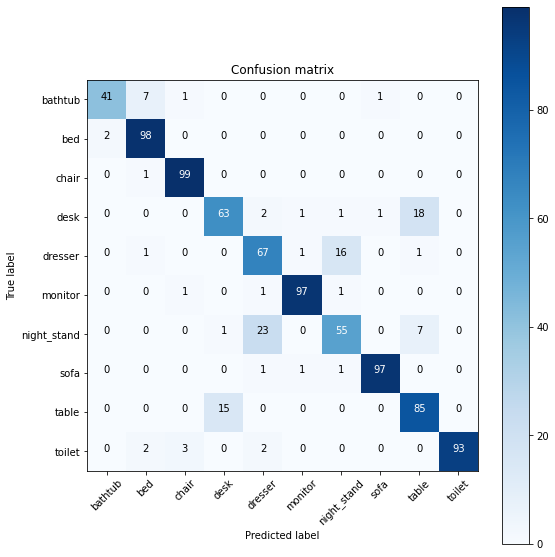

In [31]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Normalized confusion matrix


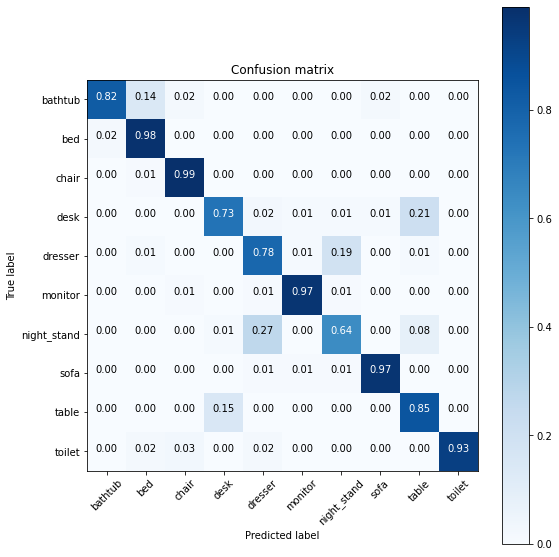

In [32]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

In [33]:
# print(history.history)
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


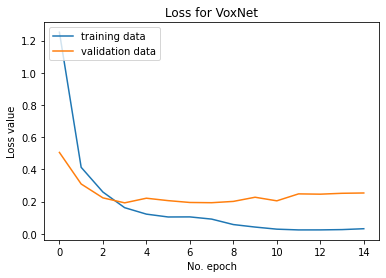

In [41]:
# Plot history: loss
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for VoxNet')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


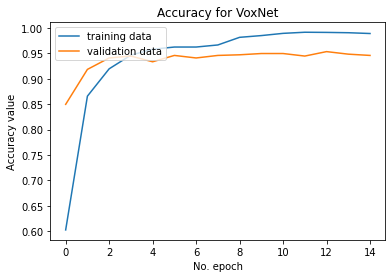

In [42]:
# Plot history: acc
plt.plot(history.history['accuracy'], label='training data')
plt.plot(history.history['val_accuracy'], label='validation data')
plt.title('Accuracy for VoxNet')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()